In [79]:
import re
import pickle
from urllib.parse import unquote, quote_plus
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 14
%matplotlib inline

from scipy.stats import skew as spskew
from scipy.stats import kurtosis as spkurt
from sklearn.preprocessing import minmax_scale, scale

In [3]:
def albums_by_genre(df, genre, drop_genres=False):
    out = df[df['genre_' + genre].astype(bool)]
    if drop_genres:
        out = df_drop_genres(out)
    return out

def albums_by_band(df, band, drop_genres=False):
    out = df_short[df_short['band'] == band]
    if drop_genres:
        out = df_drop_genres(out)
    return out

def genres_by_band():
    return

def df_drop_genres(df):
    return df[df.columns[~df.columns.str.contains('genre_')]]

def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def boxsmooth(x, w=1, pad=0):
    x_padded = padded_array(x, pad)
    kernel = np.ones(w) / w
    return smooth(x_padded, kernel, w, pad)

def gsmooth(x, w=1, pad='auto', kernel_threshold=1e-5):
    if w == 0:
        return x, np.zeros_like(x)
    if pad == 'auto':
        pad = w
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

In [81]:
files = ['bands/' + path for path in os.listdir('bands') if '.pkl' in path]
df_list = []
bands = []
genres = []
for file in files:
    try:
        with open(file, 'rb') as f:
            band = pickle.load(f)
    except:
        pass
    if band.albums is not None:
        df = band.albums
        for genre in band.genres:
            if re.search('^\w+(-*)\w+$', genre) is not None:
                genres.append(genre)
                df['genre_' + genre] = 1
        df['band'] = band.name
        df['origin'] = band.origin
        covers = pd.Series(index=df.index)
        for i, album in df.album.items():
            im_file = 'imgs/' + quote_plus(band.name.replace(' ', '_') + '-' + album + '.jpg')
            try:
                im = Image.open(im_file).resize((224, 224))
            except:
                continue
            covers[i] = im.tobytes()
        df['cover'] = covers
        df_list.append(df)
        bands.append(band)
genres = sorted(set(genres))
df_full = pd.concat(df_list).fillna(0).reset_index(drop=True)

cols = df_full.columns
genre_columns = cols[cols.str.contains('genre_')].sort_values()
for col in genre_columns:
    df_full[col] = df_full[col].astype(int)

D:\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Weighted album score

I could analyze the quality of these albums by simply looking at average review ratings, but doing so fails to weigh in each album's popularity (or infamy). There are two reasons why this matters:
* There are countless albums on MA with only a single, 100% review. To say these albums are all better than Megadeth's "Rust in Peace" is disingenuous. Although I could apply a minimum number of reviews required, this shrinks down the dataset considerably. A weighted score should be distinguish good albums based on them having many positive reviews, not just a handful.
* Using a score weighted by the number of reviews would help emphasize the "badness" of albums that are notoriously bad. Take Metallica's infamous "St. Anger": to simply look at its average review of 45% doesn't take into account the gravity of its rating. The fact that 29 reviewers all agree that the album is a steaming pile of trash should be taken into account.

I define a weighted review score that I will hereonafter refer to simply as "score" (the individual/average review ratings will just be called "ratings"). To compute this, first the average review ratings are scaled to zero mean and unit variance, so it measures standard deviations from the mean review (~79%). The number of reviews is meanwhile normalized to the max number of reviews (38 reviews for Wintersun's "Time I"). The score of an album is defined as the product of these two values, scaled to zero mean and unit variance. Thus, every review for an album that is above the global mean will increase the album's score, and every review below will decrease it. Albums with few reviews will stay near zero, even if those reviews are very positive or negative. Albums with many reviews could be anywhere on the spectrum based on the ratings.

In [85]:
df_full.sort_values('numrev', ascending=False)[:1]

,album,avgrev,band,cover,genre_acoustic,genre_alternative,genre_ambient,genre_and,genre_aor,genre_atmospheric,...,genre_trance,genre_tribal,genre_trip,genre_various,genre_viking,genre_wave,genre_with,numrev,origin,year
8373,Time_I,68,Wintersun,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,38,Finland,2012


In [86]:
df_full.avgrev.mean()

78.67359085074105

In [87]:
sigmoid = lambda x, a: 1 / (1 + np.exp(-a*x))
# rtg = sigmoid(df_full['numrev'] - df_full['numrev'].mean(), 0.1) * sigmoid(df_full['avgrev'] - df_full['avgrev'].mean(), 0.1)
numrev_scaled = minmax_scale(scale(df_full.numrev))
avgrev_scaled = scale(df_full.avgrev)
df_full['numrev_scaled'] = numrev_scaled
df_full['avgrev_scaled'] = avgrev_scaled
score = numrev_scaled * avgrev_scaled
score = scale(score)
df_full['score'] = score
df_short = df_full[['band', 'origin', 'album', 'year', 'cover', 'numrev', 'avgrev', 'score']]

Let's take a look at how album scores relate to the raw review statistics.

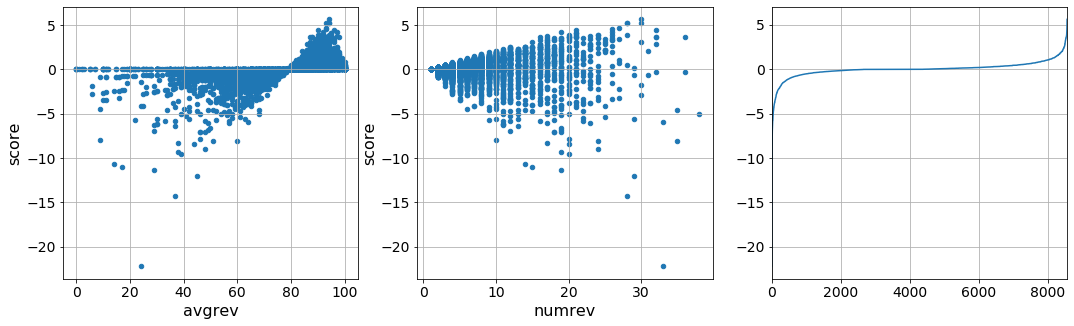

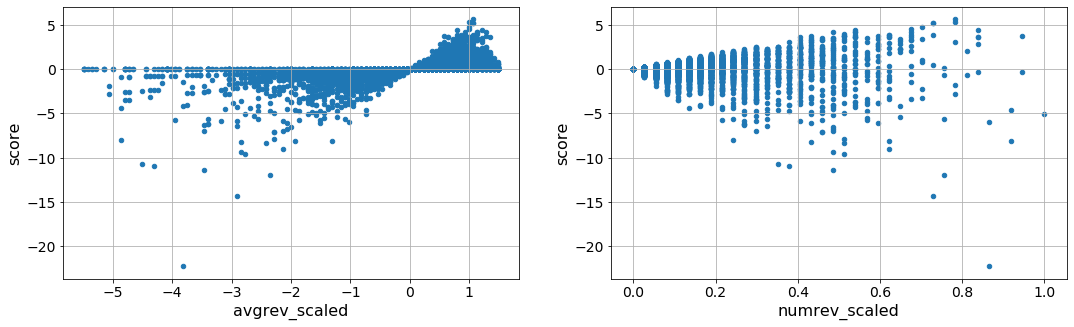

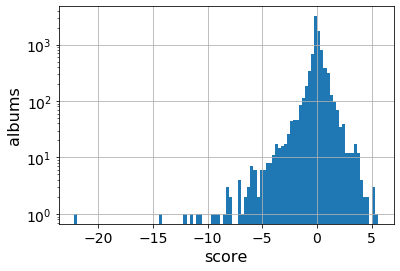

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
df_short.plot('avgrev', 'score', 'scatter', ax=ax[0])
df_short.plot('numrev', 'score', 'scatter', ax=ax[1])
df_short.score.sort_values().reset_index(drop=True).plot(ax=ax[2])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
df_full.plot('avgrev_scaled', 'score', 'scatter', ax=ax[0])
df_full.plot('numrev_scaled', 'score', 'scatter', ax=ax[1])
plt.show()

df_short.score.hist(bins=100)
plt.yscale('log')
plt.xlabel('score')
plt.ylabel('albums')
plt.show()

Score does generally increase with average review, but is more spread out where there are more reviews. Again, many poor reviews (<79%) give a low score, many high reviews (>79%) give a high score, but few reviews have a smaller impact. In case you're wondering: no, the album that scored -22 is not "St. Anger". Let's take a look at the best and worst albums to find out what this masterpiece is.

### Albums sorted by weighted rating

Below we see the best and worst scoring albums.

In [89]:
df_short.sort_values('score', ascending=False)[:20]

,band,origin,album,year,cover,numrev,avgrev,score
1032,Black Sabbath,United Kingdom,Paranoid,1970,0.0,30,94,5.609877
2127,Death,United States,Symbolic,1995,0.0,30,93,5.241888
5038,Metallica,United States,Ride_the_Lightning,1984,0.0,28,94,5.220915
1435,Burzum,Norway,Hvis_lyset_tar_oss,1994,0.0,28,94,5.220915
6770,Sepultura,Brazil,Beneath_the_Remains,1989,0.0,27,93,4.696512
3993,Iron Maiden,United Kingdom,Powerslave,1984,0.0,26,93,4.514720
4919,Megadeth,United States,Rust_in_Peace,1990,0.0,32,90,4.425368
4648,Lykathea Aflame,Czech Republic,Elvenefris,2000,0.0,21,96,4.367118
4111,Judas Priest,United Kingdom,Painkiller,1990,0.0,26,92,4.197488
4102,Judas Priest,United Kingdom,Stained_Class,1978,0.0,19,97,4.155806


In [90]:
df_short.sort_values('score', ascending=False)[-20:]

,band,origin,album,year,cover,numrev,avgrev,score
6773,Sepultura,Brazil,Roots,1996,0.0,19,49,-6.807735
6181,Queensrÿche,United States,American_Soldier,2009,0.0,12,29,-6.963622
4255,Killswitch Engage,United States,The_End_of_Heartache,2004,0.0,19,48,-7.036143
4929,Megadeth,United States,Super_Collider,2013,0.0,18,46,-7.078352
7837,Trivium,United States,The_Crusade,2006,0.0,18,46,-7.078352
1437,Burzum,Norway,Dau%C3%B0i_Baldrs,1997,0.0,20,46,-7.907561
6903,Six Feet Under,United States,Graveyard_Classics_2,2004,0.0,10,9,-7.987048
5047,Metallica,United States,Hardwired..._to_Self-Destruct,2016,0.0,35,60,-8.086529
2433,Dimmu Borgir,Norway,Abrahadabra,2010,0.0,24,51,-8.106711
3962,In Flames,Sweden,Siren_Charms,2014,0.0,17,38,-8.287976


In [91]:
[band for band in bands if (band.name == 'Waking the Cadaver')][0].genres

['brutal', 'death', 'deathcore', 'hardcore']

At -22 we have "slamming gore groove" (their words) outfit Waking the Cadaver with their 2007 album "Perverse Recollections of a Necromangler". Metal-archives is not very fond of deathcore.

### Genres sorted by average weighted rating

We can group albums by their band's genres to see which genre tags do well in the reviews.

In [92]:
genre_data = []
for genre in genres:
    df = albums_by_genre(df_full, genre, drop_genres=True)
    x = (genre, df.shape[0], df.year.min(), df.year.max(), df.score.mean(), df.score.max())
    genre_data.append(x)
genre_ratings = pd.DataFrame(genre_data, columns=['genre', 'albums', 'start', 'end', 'avgscore', 'maxscore']).sort_values('avgscore', ascending=False)
genre_ratings[genre_ratings['albums'] > 100].sort_values('avgscore', ascending=False)

,genre,albums,start,end,avgscore,maxscore
6,avant-garde,159,1985,2018,0.292570,3.859547
5,atmospheric,196,1992,2018,0.286862,3.638632
95,viking,160,1984,2018,0.225953,3.859283
21,doom,860,1970,2018,0.216928,5.609877
28,epic,176,1980,2018,0.200794,2.498179
31,folk,430,1991,2018,0.169839,3.859547
71,progressive,915,1970,2018,0.159957,5.241888
38,grindcore,212,1987,2017,0.154145,3.081622
83,sludge,159,1984,2018,0.135303,2.248798
86,stoner,136,1984,2018,0.121398,2.303697


The top of this table surprised me. I'd expected the bigger genres (black, death, etc.) to dominate, but those genres don't do so well because they're presumably saturated markets. The top few genres are a bit more niche and less bountiful in below-average albums. One could also argue that niche albums attract more flexible/tolerant reviewers, whereas the most popular genres have to be held to higher standards given the quantity of music available.

I'm just happy to see progressive metal in the top few. I would have expected a lower number considering some big names in modern progressive metal (most notably BTBAM) are not on MA.

At the bottom of the table, as one might guess, are deathcore and its related subgenres, metalcore and groove metal.

### Albums by country of origin

Enough picking on deathcore. How does the geographical distribution of metal look?

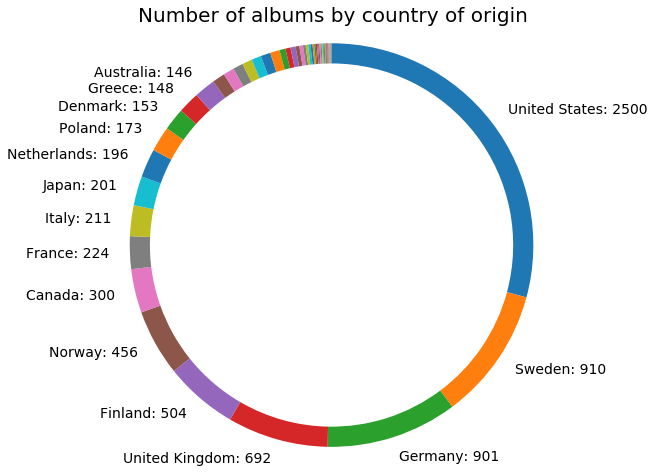

In [93]:
bands_by_origin = (
    pd.DataFrame(
        [
            (band.origin, len(albums_by_band(df_short, band.name))) 
            for band in bands
        ],
        columns=['origin', 'num_bands']
    )
    .groupby('origin')
    .sum()
    .sort_values('num_bands', ascending=False)
)

plt.figure(figsize=(8, 8))
plt.pie(
    bands_by_origin.num_bands,
    labels=[('{}: {}'.format(i, x) if x > 100 else '') for i, x in bands_by_origin.num_bands.items()],
    wedgeprops=dict(width=0.1),
    startangle=90,
    counterclock=False
)
plt.axis('equal')
plt.title('Number of albums by country of origin')
plt.show()

Clearly the United Satates dominates, with mostly Scandinavian and other European countries among the top.

### Top scoring bands

To be the among the top scoring bands, you have to consistenly put out great albums that garner lots of reviews, since any below-average albums would bring you down. The table below shows that Death is the most consistently highly-reviewed metal band. Given their discography this is no surprise. These guys really didn't know how to put out a bad album. Their lowest reviewed full-length album, "The Sound of Perseverance" averaged just 1% below the 79% global average, while the rest are all above 81%. Black Sabbath can't boast the same consistency, with their later albums pulling down their score, but they still do well thanks to their first six albums that all averaged above 87%. Rush on the other hand earn their third place spot with an unbelievably steady discography of nineteen albums, most of them above 80%.

At the bottom of the table we see the downfall of many giants of the 80's whose early successes were not enough to keep them afloat as their careers declined and their album production soldiered on in the face of disappointed fans. Oh, and there's deathcore.

In [94]:
df_bands = pd.DataFrame(index=df_short.band.drop_duplicates(), columns=['numrev', 'avgrev'])
for band in df_bands.index:
    df_band = df_short[df_short.band == band]
    numrev = df_band.numrev.sum()
    avgrev = (df_band.avgrev * df_band.numrev).sum() / numrev
    df_bands.loc[band, :] = [numrev, avgrev]

numrev_scaled = minmax_scale(scale(df_bands.numrev))
avgrev_scaled = scale(df_bands.avgrev)
df_bands['numrev_scaled'] = numrev_scaled
df_bands['avgrev_scaled'] = avgrev_scaled
score = numrev_scaled * avgrev_scaled
score = scale(score)
df_bands['score'] = score

In [102]:
df_bands.sort_values('score', ascending=False)[:15]

,numrev,avgrev,numrev_scaled,avgrev_scaled,score
band,,,,,
Death,164,87.0854,0.439353,0.839083,3.857503
Black Sabbath,334,82.976,0.897574,0.370679,3.486791
Rush,172,85.6977,0.460916,0.680906,3.292150
Candlemass,99,88.5051,0.264151,1.000907,2.782111
Blind Guardian,178,84.5393,0.477089,0.548871,2.756012
Type O Negative,73,91.0548,0.194070,1.291542,2.640385
Angra,73,90.7945,0.194070,1.261874,2.581000
Bolt Thrower,107,87.1215,0.285714,0.843201,2.539977
Immolation,91,88.1209,0.242588,0.957117,2.449934


In [103]:
df_bands.sort_values('score', ascending=False)[-15:]

,numrev,avgrev,numrev_scaled,avgrev_scaled,score
band,,,,,
Killswitch Engage,75,61.8667,0.199461,-2.035491,-4.132440
Winds of Plague,35,40.2857,0.091644,-4.495414,-4.194095
Iced Earth,172,71.7384,0.460916,-0.910257,-4.272212
Lacuna Coil,73,60.3699,0.194070,-2.206106,-4.360778
Slayer,247,73.8178,0.663073,-0.673230,-4.549129
Whitechapel,62,55.5323,0.164420,-2.757524,-4.621256
Annihilator,167,69.7545,0.447439,-1.136391,-5.189287
Megadeth,339,74.531,0.911051,-0.591940,-5.507184
Waking the Cadaver,45,32.8,0.118598,-5.348680,-6.487624


To better visualize the decline of heavy metal giants, we can plot the scores of all of the top bands by weighted review score against the number of years since their full-length debut. A downward trend throughout the first 10-15 years is quite noticeable in most bands.

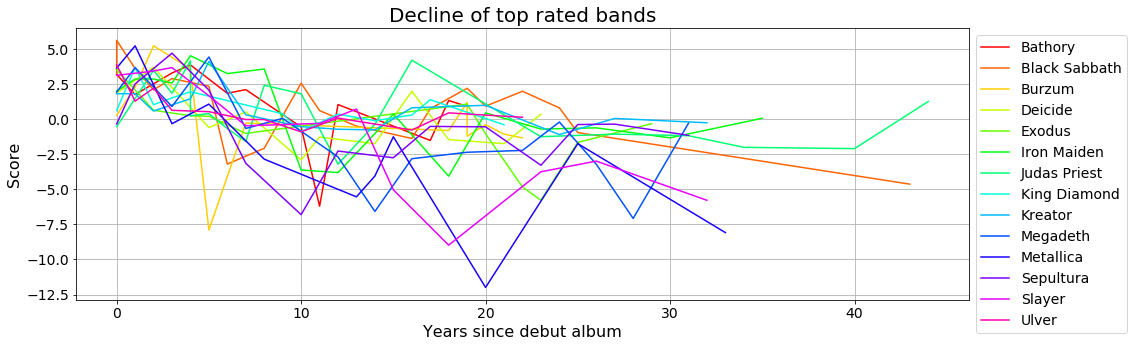

In [104]:
band_scores = {}
for band in df_short.band.drop_duplicates():
    df_band = df_short[df_short.band == band]
    if df_band.score.max() > 3.5 and df_band.shape[0] > 10:
        band_scores[band] = [df_band.year, df_band.score]
plt.figure(figsize=(16, 5))
cmap = plt.cm.hsv
plt.gca().set_prop_cycle(color=[cmap(i) for i in np.linspace(0, 0.9, len(band_scores))])
for band, (years, scores) in band_scores.items():
    plt.plot(years - years.values[0], scores, label=band)
plt.title('Decline of top rated bands')
plt.xlabel('Years since debut album')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Global trends

Now for a more comprehensive look. We can see that the number of metal albums grew up until the late 2000's, and has been in sharp decline since. The average score suggests that 1970 was by far the most highly-rated year in metal history, but this is skewed by the fact that there were just four albums that early on, all of which have high scores (including Black Sabbath's first two albums). It's better to sum up the scores from each year than to average them, in order to weigh in the number of albums released that year. Doing so shows that the overall quality of metal albums peaked towards the end of the 80s, not surprisingly the same time that many of those top bands from above were releasing their most iconic albums. As the metal scene saturated, the quality dropped, hitting a low point that coincides with the peak in number of albums.

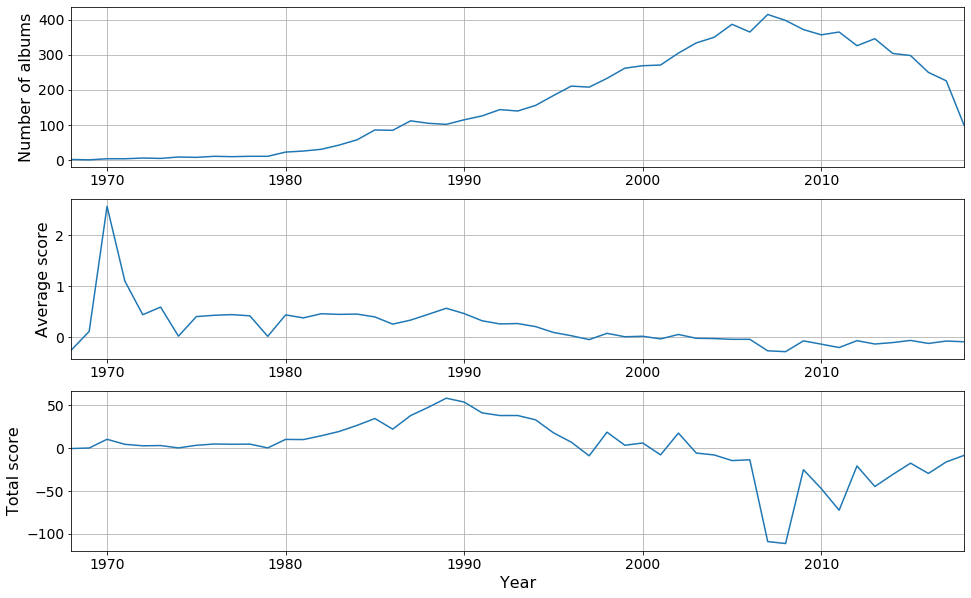

In [105]:
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
df_short.groupby('year').size().plot(ax=ax[0])
df_short.groupby('year')['score'].mean().plot(ax=ax[1])
df_short.groupby('year')['score'].sum().plot(ax=ax[2])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Year')
ax[0].set_ylabel('Number of albums')
ax[1].set_ylabel('Average score')
ax[2].set_ylabel('Total score')
plt.show()

# Genre trends

Now let's break the trends down by genre to see how metal has changed over the decades.

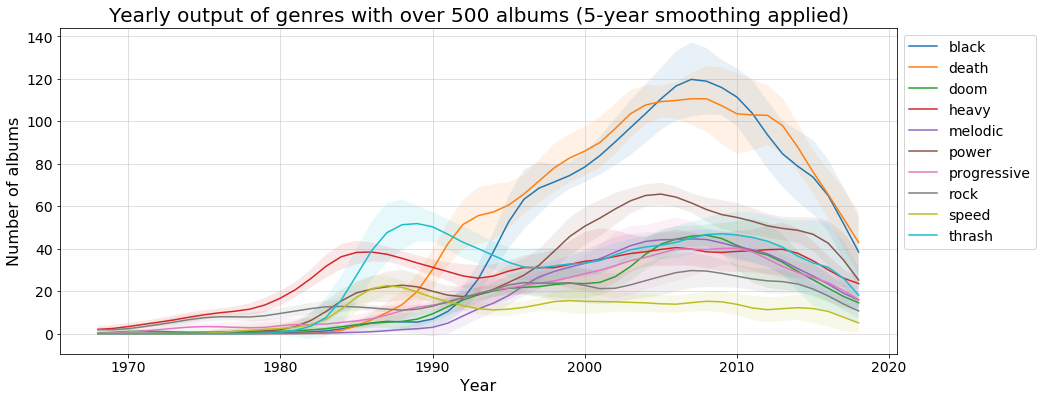

In [106]:
min_albums = 500
smoothing = 5
genre_years = df_full.groupby('year')[df_full.columns[df_full.columns.str.contains('genre_')]].sum()
plt.figure(figsize=(15, 6))
for i, col in genre_years.iteritems():
    if col.sum() > min_albums:
        x = col.index
        y, y_std = gsmooth(col.values, smoothing)
        plt.plot(x, y, label=i.replace('genre_', ''))
        plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Number of albums')
if smoothing > 0:
    title = 'Yearly output of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly output of genres with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

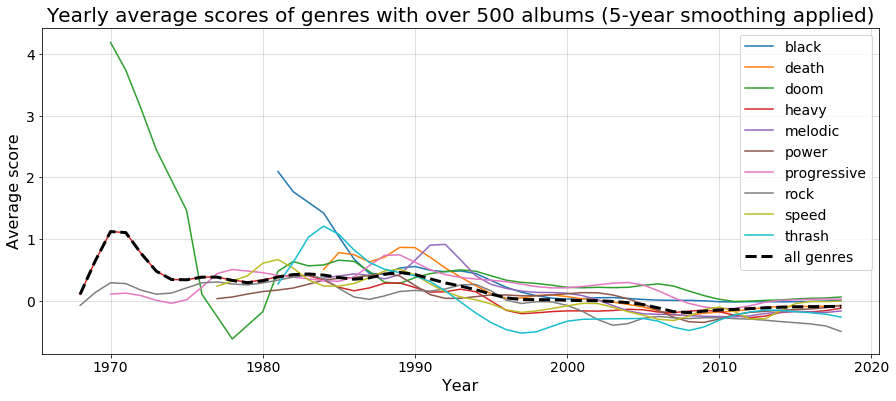

In [107]:
min_albums = 500
smoothing = 5
plt.figure(figsize=(15,6))
for genre in genres:
    df = albums_by_genre(df_full, genre)[['year', 'score']].sort_values('year').reset_index(drop=True)
    if len(df) > min_albums:
        series = df.groupby('year').score.mean()
        x = series.index
        y, y_std = gsmooth(series.values, smoothing)
#         plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
        plt.plot(x, y, label=genre.replace('genre_', ''))
avg = df_short.groupby('year').score.mean()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
plt.plot(x, y, 'k--', lw=3, label='all genres')
# plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, color='k', alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Average score')
if smoothing > 0:
    title = 'Yearly average scores of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly average scores of genres with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

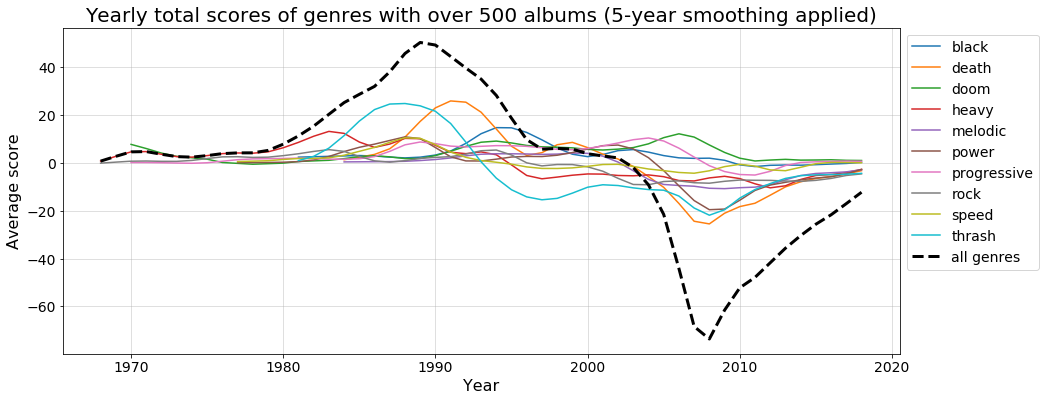

In [108]:
min_albums = 500
smoothing = 5
plt.figure(figsize=(15, 6))
for genre in genres:
    df = albums_by_genre(df_full, genre)[['year', 'score']].sort_values('year').reset_index(drop=True)
    if len(df) > min_albums:
        series = df.groupby('year').score.sum()
        x = series.index
        y, y_std = gsmooth(series.values, w=smoothing)
        plt.plot(x, y, label=genre.replace('genre_', ''))
#         plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
total = df_short.groupby('year').score.sum()
# total = df_short.groupby('year').score.apply(lambda x: np.sign(x.sum()) * np.sqrt(np.sum(x**2)))
x = total.index
y, y_std = gsmooth(total.values, w=smoothing)
plt.plot(x, y, 'k--', lw=3, label='all genres')
# plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, color='k', alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Average score')
if smoothing > 0:
    title = 'Yearly total scores of genres with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly total scores of genres with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

# Country trends

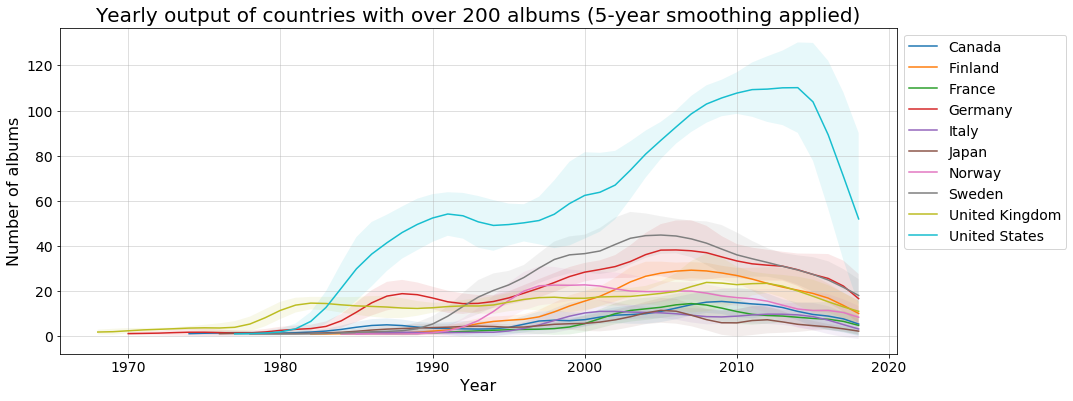

In [109]:
min_albums = 200
smoothing = 5
countries_albums = df_short.groupby('origin').size()
countries = countries_albums[countries_albums > 100]
plt.figure(figsize=(15, 6))
for country in countries.index:
    df = df_short[df_short['origin'] == country]
    if len(df) > 200:
        series = df.groupby('year').size()
        x = series.index
        y, y_std = gsmooth(series.values, smoothing)
        plt.plot(x, y, label=country)
        plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Number of albums')
if smoothing > 0:
    title = 'Yearly output of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly output of countries with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

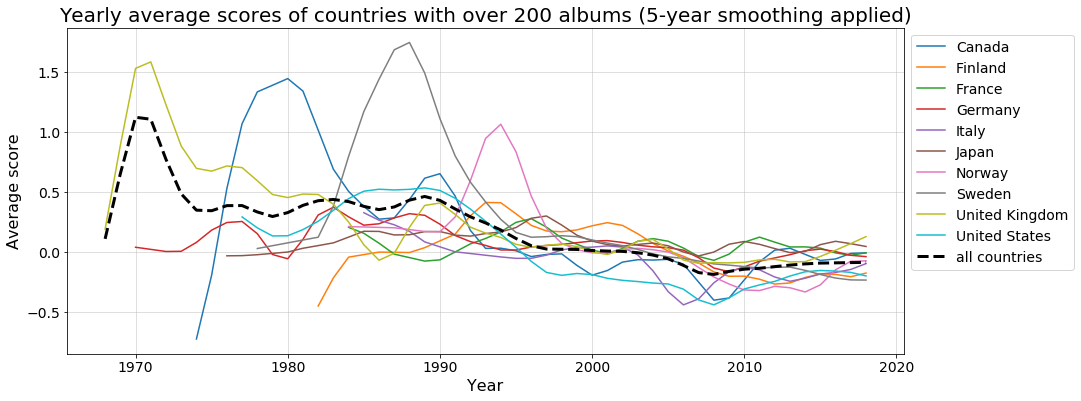

In [110]:
min_albums = 200
smoothing = 5
countries_albums = df_short.groupby('origin').size()
countries = countries_albums[countries_albums > min_albums]
plt.figure(figsize=(15, 6))
for country in countries.index:
    df = df_short[df_short['origin'] == country]
    series = df.groupby('year').score.mean()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
#     plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
    plt.plot(x, y, label=country)
avg = df_short.groupby('year').score.mean()
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
plt.plot(x, y, 'k--', lw=3, label='all countries')
# plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, color='k', alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Average score')
if smoothing > 0:
    title = 'Yearly average scores of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly average scores of countries with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

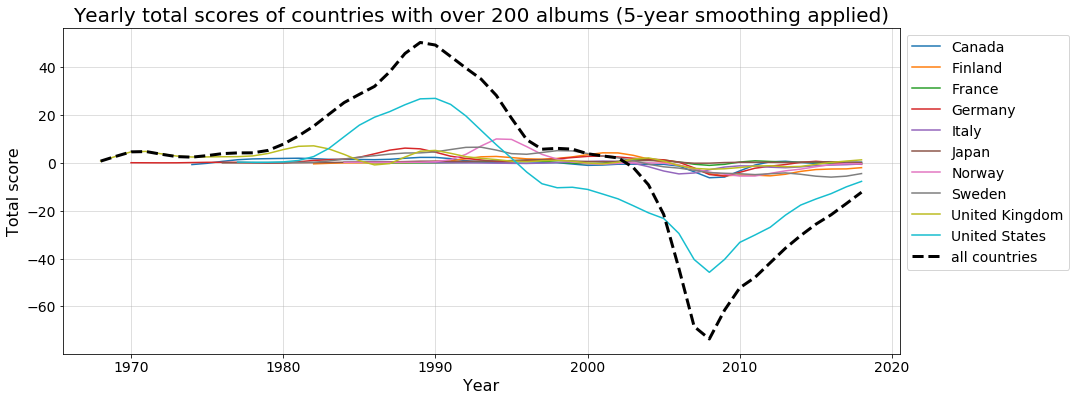

In [111]:
min_albums = 200
smoothing = 5
countries_albums = df_short.groupby('origin').size()
countries = countries_albums[countries_albums > min_albums]
plt.figure(figsize=(15, 6))
for country in countries.index:
    df = df_short[df_short['origin'] == country]
    series = df.groupby('year').score.sum()
    x = series.index
    y, y_std = gsmooth(series.values, smoothing)
#     plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, alpha=0.1)
    plt.plot(x, y, label=country)
avg = df_short.groupby('year').score.sum()
# avg = df_short.groupby('year').score.apply(lambda x: np.sign(x.sum()) * np.sqrt(np.sum(x**2)))
x = avg.index
y, y_std = gsmooth(avg.values, smoothing)
plt.plot(x, y, 'k--', lw=3, label='all countries')
# plt.fill_between(x, y - 2 * y_std, y + 2 * y_std, color='k', alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Total score')
if smoothing > 0:
    title = 'Yearly total scores of countries with over {} albums ({}-year smoothing applied)'.format(min_albums, smoothing)
else:
    title = 'Yearly total scores of countries with over {} albums'.format(min_albums)
plt.title(title)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(alpha=0.5)
plt.show()

# Top 10 genres in each country

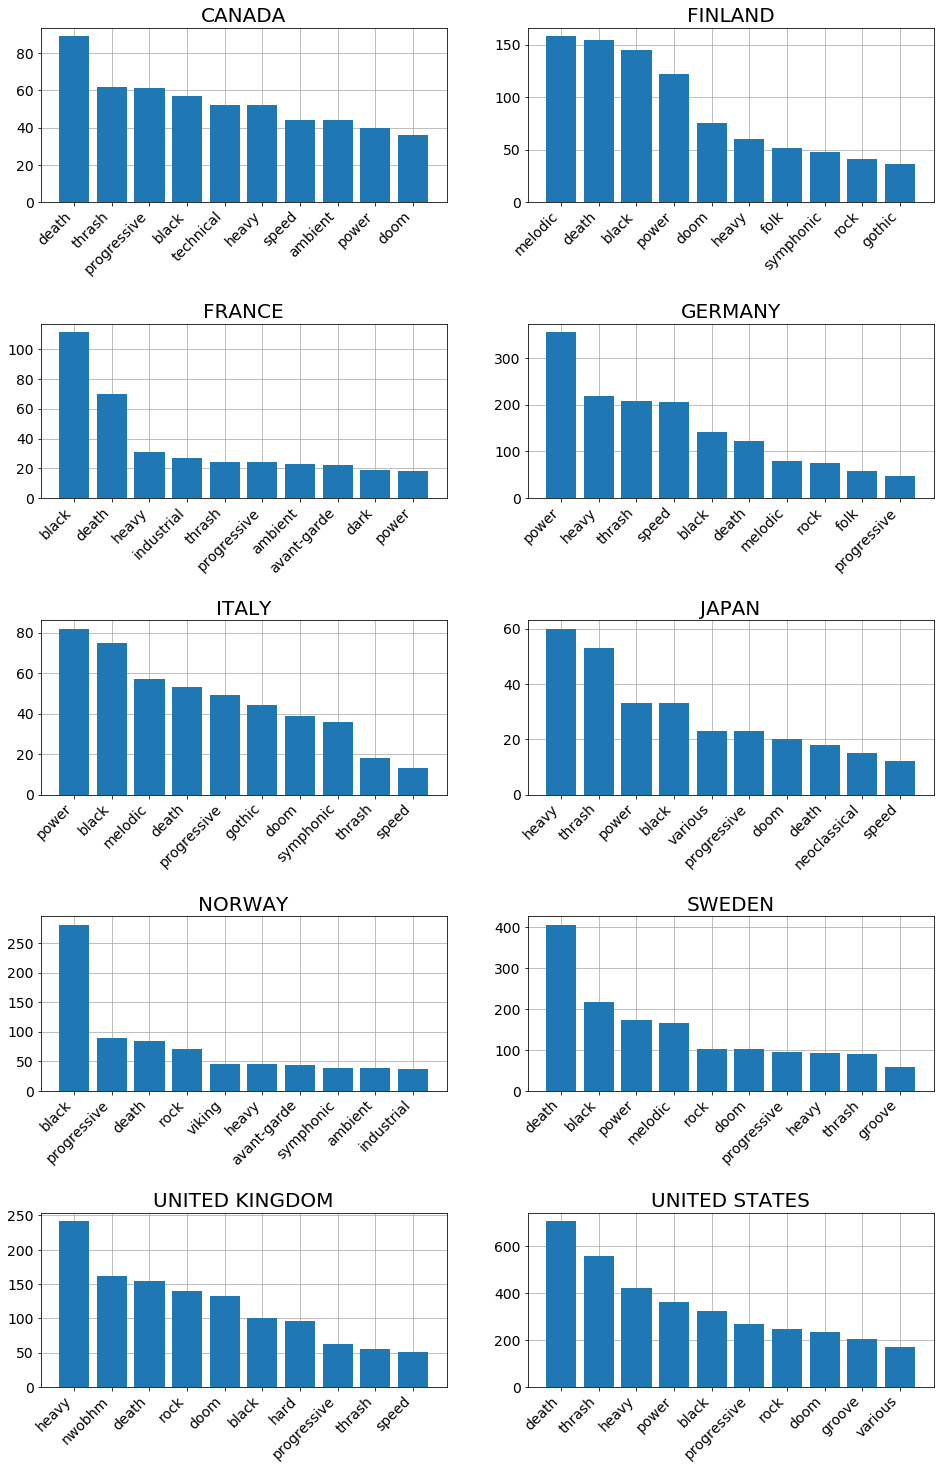

In [112]:
ncols = 2
nrows = int(np.ceil(len(countries.index) / ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))
plt.subplots_adjust(hspace=0.7)
for i, country in enumerate(countries.index):
    df_country = df_full[df_full['origin'] == country]
    popular_genres = []
    albums_in_genre = []
    for genre in genres:
        num_albums = df_country['genre_' + genre].sum()
        if num_albums > 10:
            popular_genres.append(genre)
            albums_in_genre.append(num_albums)
    x, y = [
        list(k[::-1]) for k in 
        zip(
            *sorted(
                zip(popular_genres, albums_in_genre),
                key=lambda pair: pair[1]
            )
        )
    ]
    x = x[:10]
    y = y[:10]
    ax_ = ax[i // ncols, i % ncols]
    ax_.bar(x, y, zorder=3)
    ax_.set_title(country.upper())
    plt.setp(ax_.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax_.grid(True)
plt.show()